In [1]:
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm


def generate_logits(model: torch.nn.Module, dataloader: DataLoader):
    logits = []
    device = model.device
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x = x.to(device)
            l = model(x)
            logits.append(l)
        return torch.cat(logits, dim=0)

In [4]:
from modelling.pretrained import lenet_trained_on_mnist
from datasets import MnistDataModule

model = lenet_trained_on_mnist().cuda(2)
data = MnistDataModule(shift_transform_type='natural',
                       test_transform_rate=.5,
                       rotation=(45, 90),
                       crop=.2,
                       distortion=.8,
                       batch_size=512,
                      train_val_seed = 42,
                        test_seed = 42,
                    test_sample_fraction= 1)
train_embs = generate_logits(model, data.train_dataloader())

100%|███████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.07it/s]


In [5]:
import numpy as np

In [6]:
np.savetxt('mnist-train.txt', train_embs.cpu().numpy())

In [7]:
val_embs = generate_logits(model, data.val_dataloader())
# test_embs = generate_logits(model, data.test_dataloader())

100%|███████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.80it/s]


In [8]:
np.savetxt('mnist-val.txt', val_embs.cpu().numpy())
# np.savetxt('mnist-test.txt', test_embs.cpu().numpy())

In [17]:
for i in [.001, .005,.01, 0.05,.1, .5,1]:
    data = MnistDataModule(shift_transform_type='natural',
                       test_transform_rate=.5,
                       rotation=(45, 90),
                       crop=.2,
                       distortion=.8,
                       batch_size=512,
                      train_val_seed = 42,
                        test_seed = 42,
                    test_sample_fraction= i)
    embs = generate_logits(model, data.test_dataloader())
    np.savetxt(f'mnist-test-{int(10000 * i)}.txt', embs.cpu().numpy())

Global seed set to 42
  0%|                                                             | 0/1 [00:00<?, ?it/s]/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /opt/conda/conda-bld/pyt

In [30]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from tqdm import tqdm

In [4]:
p = pd.read_json('../logits_mnist_none.json')

In [30]:
np.array(p.iloc[-1].logits)[:, 0].shape

(10, 10000)

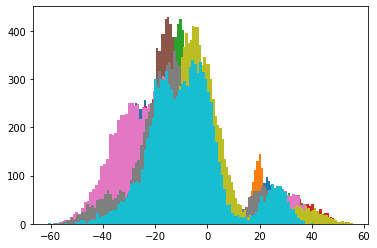

In [37]:
[plt.hist(x, 100) for x in np.array(p.iloc[-1].logits)];

In [5]:
val_sizes = [10, 10000] 
val_sets = [np.array(p[p.n_test==x].logits.tolist()) for x in val_sizes]

In [31]:
def ks_test_batch(p, q):
    """
    p is the set of validation runs (10 runs x 10 classes x n samples)
    q is another set of runs (10 runs x 10 classes x k samples)
    """
    n = p.shape[-1]
    k = q.shape[-1]
    classes = p.shape[1]
    res = [[] for _ in range(classes)]
    
    for c in tqdm(range(classes)):
        # get the logits from p and q with class c  
        pp = p[:, c]
        qq = q[:, c]
        for p_run in pp:
            for q_run in qq:
                res[c].append(ks_2samp(p_run, q_run).pvalue)
    return (n, k), np.array(res).T.tolist()

In [38]:
res = {} 
for vs, n in zip(val_sets, val_sizes):
    for nq in p.n_test.unique():
        q_logits = np.array(p[p.n_test == nq].logits.tolist())
        k, v = ks_test_eval(vs, q_logits)
        assert k == (n, nq)
        res[k] = v

100%|██████████████████████████████████████████████| 10/10 [00:05<00:00,  1.97it/s]


In [45]:
with open('../bbsd_mnist_no_shift.json', 'w') as f:
        json.dump({f'{k}': v for k,v in res.items()}, f)

In [44]:
json

<module 'json' from '/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/json/__init__.py'>